## Image Registration using RANSAC (Random Sample Consensus)
- Purpose: RANSAC is used to estimate parameters of a mathematical model from data containing outliers
- Application in Image Registration: Finds the transformation (homography) between two images by filtering out incorrect feature matches

### Import Libraries and Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from glob import glob
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.2.6


### Load Images for Registration

Looking for images in current directory...

Successfully loaded images:
Base image: assets/arceus.png - Shape: (225, 225)
Target image: assets/pikachu.png - Shape: (224, 224)


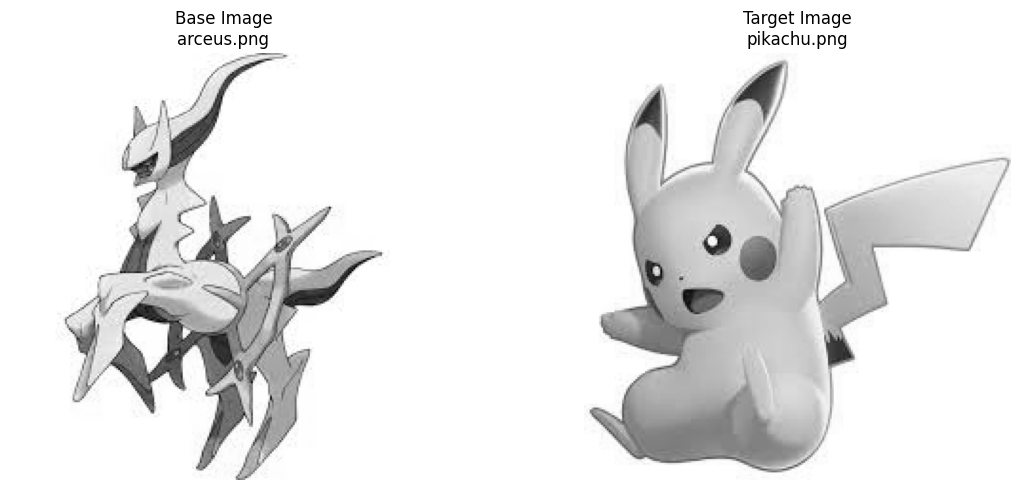


Note: RANSAC works best when images have overlapping content or show the same object/scene


In [2]:
# Function to load images from directory or file
def load_image(image_path, color_mode='grayscale'):
    """
    Load image from file path
    color_mode: 'grayscale' or 'color'
    """
    if color_mode == 'grayscale':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    return img

# List available images in current directory
print("Looking for images in current directory...")
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
available_images = []
for ext in image_extensions:
    available_images.extend(glob(ext))
    available_images.extend(glob(ext.upper()))

if len(available_images) > 0:
    print(f"Found {len(available_images)} images:")
    for i, img_path in enumerate(available_images[:10]):
        print(f"  {i+1}. {img_path}")

# Load two images for RANSAC registration
IMAGE_PATH_1 = "assets/arceus.png"  # Replace with your first image path
IMAGE_PATH_2 = "assets/pikachu.png"  # Replace with your second image path

# Use first two available images if paths not specified
if len(available_images) >= 2:
    if not os.path.exists(IMAGE_PATH_1):
        IMAGE_PATH_1 = available_images[0]
    if not os.path.exists(IMAGE_PATH_2):
        IMAGE_PATH_2 = available_images[1]

# Load images
try:
    img1 = load_image(IMAGE_PATH_1, 'grayscale')
    img2 = load_image(IMAGE_PATH_2, 'grayscale')
    
    print(f"\nSuccessfully loaded images:")
    print(f"Base image: {IMAGE_PATH_1} - Shape: {img1.shape}")
    print(f"Target image: {IMAGE_PATH_2} - Shape: {img2.shape}")
    
    # Display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(f'Base Image\n{os.path.basename(IMAGE_PATH_1)}')
    axes[0].axis('off')
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(f'Target Image\n{os.path.basename(IMAGE_PATH_2)}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\nNote: RANSAC works best when images have overlapping content or show the same object/scene")
    
except Exception as e:
    print(f"\nError loading images: {e}")
    print("Please ensure you have uploaded images or update IMAGE_PATH_1 and IMAGE_PATH_2 variables.")

### Feature Detection and Matching

Keypoints detected - Image 1: 136, Image 2: 83
Total matches found: 136
Good matches after ratio test: 1


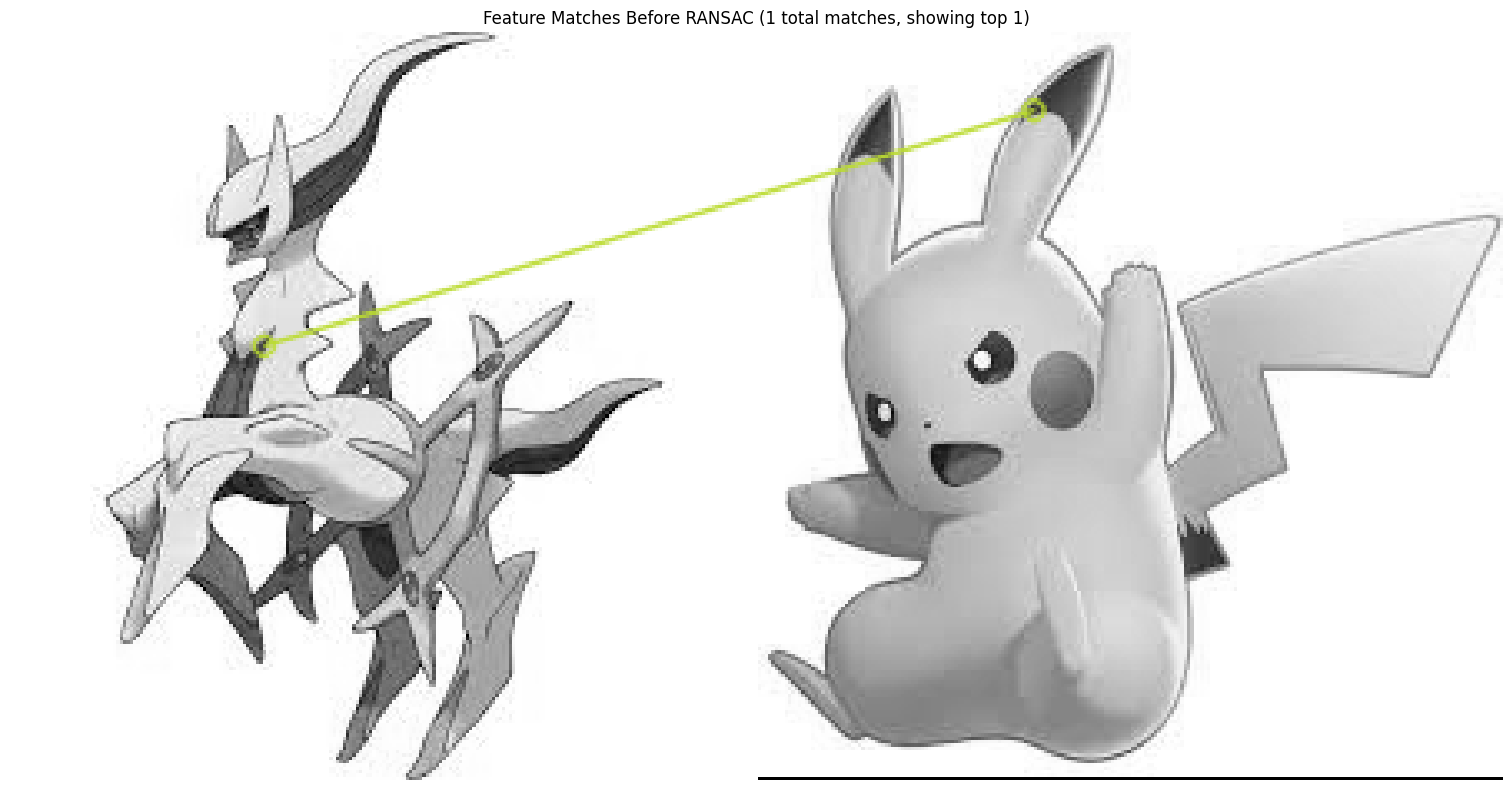

In [3]:
# Detect SIFT features
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Keypoints detected - Image 1: {len(kp1)}, Image 2: {len(kp2)}")

# Use FLANN matcher for better performance
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Find matches using KNN (k=2 for ratio test)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for match_pair in matches:
    if len(match_pair) == 2:  # Ensure we have 2 matches
        m, n = match_pair
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

print(f"Total matches found: {len(matches)}")
print(f"Good matches after ratio test: {len(good_matches)}")

# Visualize matches before RANSAC
num_display = min(50, len(good_matches))
img_matches_before = cv2.drawMatches(img1, kp1, img2, kp2, 
                                      good_matches[:num_display], None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches_before, cmap='gray')
plt.title(f'Feature Matches Before RANSAC ({len(good_matches)} total matches, showing top {num_display})')
plt.axis('off')
plt.tight_layout()
plt.show()

### Apply RANSAC for Homography Estimation

In [4]:
# Check if we have enough matches
MIN_MATCH_COUNT = 10

if len(good_matches) >= MIN_MATCH_COUNT:
    # Extract location of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    
    # Count inliers and outliers
    inliers = np.sum(matches_mask)
    outliers = len(matches_mask) - inliers
    
    print(f"\nRANSAC Results:")
    print(f"Total matches: {len(good_matches)}")
    print(f"Inliers: {inliers}")
    print(f"Outliers: {outliers}")
    print(f"Inlier ratio: {inliers/len(good_matches)*100:.2f}%")
    print(f"\nHomography Matrix:")
    print(H)
    
    # Draw only inlier matches
    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=None,
                       matchesMask=matches_mask,
                       flags=2)
    
    img_matches_after = cv2.drawMatches(img1, kp1, img2, kp2, 
                                         good_matches, None, **draw_params)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(img_matches_after)
    plt.title(f'Inlier Matches After RANSAC ({inliers} inliers, {outliers} outliers removed)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Visualize inlier vs outlier distribution
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    labels = ['Inliers', 'Outliers']
    sizes = [inliers, outliers]
    colors = ['#2ecc71', '#e74c3c']
    explode = (0.1, 0)
    
    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=90)
    ax.set_title('RANSAC: Inliers vs Outliers')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\nNot enough matches found - {len(good_matches)}/{MIN_MATCH_COUNT}")
    print("RANSAC requires at least 10 good matches for homography estimation")
    H = None
    matches_mask = None


Not enough matches found - 1/10
RANSAC requires at least 10 good matches for homography estimation


### Apply Registration and Visualize Results

In [5]:
if H is not None:
    # Get dimensions
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    # Warp the base image to align with target image
    registered_img = cv2.warpPerspective(img1, H, (w2, h2))
    
    # Calculate registration error
    error = np.abs(registered_img.astype(float) - img2.astype(float))
    mean_error = np.mean(error)
    
    print(f"\nRegistration Quality:")
    print(f"Mean pixel error: {mean_error:.2f}")
    print(f"Max pixel error: {np.max(error):.2f}")
    print(f"Min pixel error: {np.min(error):.2f}")
    print(f"Standard deviation: {np.std(error):.2f}")
    
    # Display results
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title('Original Base Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img2, cmap='gray')
    axes[0, 1].set_title('Target Image')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(registered_img, cmap='gray')
    axes[1, 0].set_title('Registered Image (Warped)')
    axes[1, 0].axis('off')
    
    im = axes[1, 1].imshow(error, cmap='hot')
    axes[1, 1].set_title(f'Registration Error\n(Mean: {mean_error:.2f})')
    axes[1, 1].axis('off')
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Create overlay visualization
    alpha = 0.5
    overlay = cv2.addWeighted(registered_img, alpha, img2, 1-alpha, 0)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(overlay, cmap='gray')
    plt.title('Overlay: Registered Image + Target Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
else:
    print("Skipping registration visualization - homography not computed")

Skipping registration visualization - homography not computed
